# Die Corona Lage 

## Daten URLs

In [81]:
URL_CORONA_INFECTED = r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
URL_CORONA_RECOVER = r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
URL_CORONA_DEATHS = r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
URL_CORONA_METADATA = r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv"


## Umsetzung

### Import

In [82]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools as itools
import re

### Herunterladen der Daten von Github

In [83]:
infected = pd.read_csv(URL_CORONA_INFECTED).drop(['Lat', 'Long'], axis=1)
recovered = pd.read_csv(URL_CORONA_RECOVER).drop(['Lat', 'Long'], axis=1)
death = pd.read_csv(URL_CORONA_DEATHS).drop(['Lat', 'Long'], axis=1)
population = pd.read_csv(URL_CORONA_METADATA)
population = population.dropna(subset=['Population'])
population = population.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Combined_Key', 'Lat', 'Long_'], axis=1)
population = population[population.isnull().any(axis=1)]
population = population.drop(['Admin2'], axis=1)


def GetCountries(excludeShips = True) ->list:
    ret = infected['Country/Region'].unique().tolist()
    if excludeShips:
        ret.remove('Diamond Princess')
        ret.remove('MS Zaandam')
    return ret
def GetStates(Country:str) ->list:
    return infected.loc[infected['Country/Region'] == Country]['Province/State'].unique().tolist()

def GetCountryStateCount():
    ret = []
    for country in GetCountries():
        states = GetStates(country)
        count = len(states)
        if count > 1:
            ret += [(country, count, states)]
    return ret


In [84]:
def Per100k(value: int, population:float)->float:
    return value / (population / 100000)

def MeanNumpyValues(data: np.ndarray, TickLength=7)->np.ndarray:
    result = []
    Ticks = math.floor(len(data)/TickLength)
    for i in range(Ticks):
        result += [np.mean(data[i * TickLength:i * TickLength + TickLength])]
    if((len(data) % TickLength) != 0):
        result += [np.mean(data[Ticks * TickLength:])]
    return np.array(result)

def GetCount_Leading_Zero(data: np.ndarray)->int:
    for i, c in enumerate(data):
        if c != 0:
            return i
    return 0
def IsWorld(Country: str)->bool:
    if re.match('^world$', Country, flags=re.IGNORECASE):
        return True
    return False

In [85]:
def GetCountryData(Country: str, data: pd.DataFrame)->pd.DataFrame:
    if IsWorld(Country):
        return data
    return data.loc[data['Country/Region'] == Country]

def GetDates()->np.ndarray:
    return np.array([datetime.datetime.strptime(s, '%m/%d/%y' ) for s in infected.columns.values[2:]])

def GetInfectedData(Country: str, State=[])->np.ndarray:
    return GetData(infected, Country, State)

def GetRecoveredData(Country: str, State=[]) ->np.ndarray:
    return GetData(recovered, Country, State)

def GetDeathData(Country: str, State=[]) ->np.ndarray:
    return GetData(death, Country,State)

def GetActiveData(Country: str, State=[]) ->np.ndarray:
    return GetInfectedData(Country,State) - GetRecoveredData(Country, State) - GetDeathData(Country, State)

def GetDailyActiveData(Country: str, State=[])->np.ndarray:
    return GetDailyInfectedData(Country, State)- GetDailyDeathData(Country, State) - GetDailyRecoveredData(Country, State)

def GetDailyDeathData(Country: str, State=[])->np.ndarray:
    return GetDailyData(death, Country, State)

def GetDailyInfectedData(Country: str, State=[]):
    return GetDailyData(infected, Country, State)

def GetDailyRecoveredData(Country: str, State=[]):
    return GetDailyData(recovered, Country, State)

def GetDailyData(data: pd.DataFrame, Country: str, State) ->np.ndarray:
    data = np.concatenate([np.zeros(1), GetData(data, Country, State)])
    return data[1:] - data[:-1]

def GetTitle(Country: str, States = [])->str:
    if(len(States) == 0):
        States = ["total"]
    return "%s - %s" % (Country, ", ".join(States))

def GetData(data: pd.DataFrame, Country: str, State)->np.ndarray:
    countryData = GetCountryData(Country, data)
    if(len(State) == 0):
        return np.sum(countryData.values[:,2:], axis=0)
    else:
        return np.sum(countryData[countryData['Province/State'].isin(State)].values[:,2:], axis=0)

def GetPopulation(Country: str, States=[]):
    if IsWorld(Country):
        return 7802045000
    countryData = GetPopulation_Data(Country)
    if(len(States) == 0):
        return np.sum(countryData.values[:,2:], axis=0)[0,]
    else:
        return np.sum(countryData[countryData['Province_State'].isin(States)].values[:,2:], axis=0)[0,]


def GetPopulation_Data(Country:str)->pd.DataFrame:
    d = population.loc[population['Country_Region'] == Country]
    if(len(d) > 1):
        d = d[d['Province_State'].isin(GetStates(Country))]
    return d

In [86]:

def Plot_Data(Country: str, States=[], log=True, X_Tick_Count=2):
    dates = GetDates()
    plt.plot(dates, GetInfectedData(Country, States), c='yellow', label="infected")
    plt.plot(dates, GetDeathData(Country, States), c='red', label="death")
    plt.plot(dates, GetRecoveredData(Country, States), c='green', label="recovered")
    if log:
        plt.yscale('log')
    plt.xticks(GetTicks(dates, X_Tick_Count))
    plt.ylabel('total cases')
    plt.xlabel('time')
    plt.autoscale(axis='x', tight=True)
    plt.show()

def Plot_ActiveCases(Country: str, State=[], log=True, X_Tick_Count=2):
    dates=GetDates()
    plt.plot(dates,GetActiveData(Country, State))
    if log:
        plt.yscale('log')
    plt.xticks(GetTicks(dates, X_Tick_Count))
    plt.ylabel('active cases')
    plt.xlabel('time')
    plt.autoscale(axis='x', tight=True)
    plt.show()

def Plot_Daily(Country: str, State=[], log=False, X_Tick_Count=2):
    dates = GetDates()
    plt.plot(dates, GetDailyInfectedData(Country, State), c='yellow')
    plt.plot(dates, GetDailyDeathData(Country, State), c='red')
    plt.plot(dates, GetDailyRecoveredData(Country, State), c='green')
    if log:
        plt.yscale('log')
    plt.xticks(GetTicks(dates, X_Tick_Count))
    plt.ylabel('daily cases')
    plt.xlabel('time')
    plt.autoscale(axis='x', tight=True)
    plt.show()

def Plot_Existing_Over_New(Country: str, State=[], log=True, X_Tick_Count=2):
    plt.plot(GetInfectedData(Country, State), GetDailyInfectedData(Country,State))
    if log:
        plt.yscale('log')
        plt.xscale('log')
    plt.ylabel('daily cases')
    plt.xlabel('total cases')
    plt.autoscale(axis='x', tight=True)
    plt.show()

def Plot_Existing_Over_New_2(Countries: list):
    for Country in Countries:
        plt.plot(MeanNumpyValues(GetInfectedData(Country)), MeanNumpyValues(GetDailyInfectedData(Country)), label=Country)
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.ylabel('daily cases')
    plt.xlabel('total cases')
    plt.autoscale(axis='x', tight=False)
    plt.show()



def GetTicks(dates: np.ndarray, Count = 2)->np.ndarray:
    if Count == 2:
        return dates[0::len(dates)-1]
    elif Count > 2:
        return dates[0::math.floor((len(GetDates()) - 1)/(Count - 1))]

def GetInnerTitle(Country:str, States:list)-> str:
    if(len(States) == 0):
        States = ["total"]
    return "Information for %s - %s (%s)" % (Country, ", ".join(States), GetDates()[-1].date())

def GetHashtagList(Count: int)->str:
    return "".join(itools.repeat('#', Count))




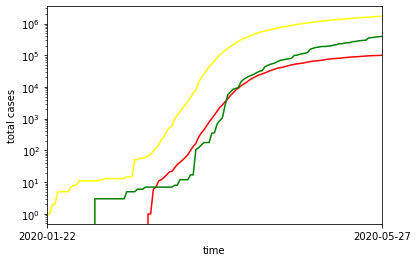

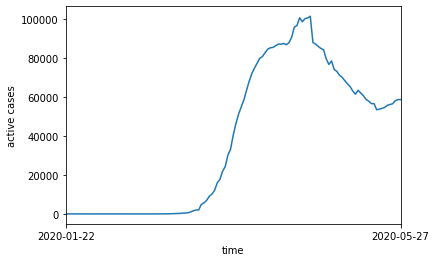

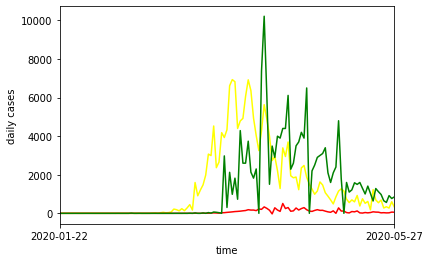

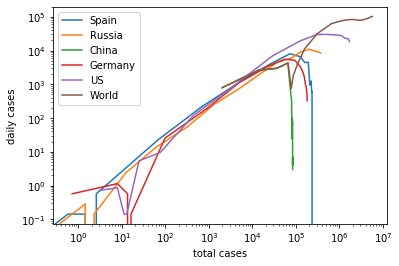

In [87]:
Plot_Data('US')
Plot_ActiveCases('Spain', log=False)
Plot_Daily('Germany')
Plot_Existing_Over_New_2(['Spain', 'Russia', 'China', 'Germany', 'US', 'World'])

In [88]:
def GetTotal_Data(cinfected: np.ndarray, crecovered: np.ndarray, cdeath:np.ndarray)->tuple:
    totalinfected = cinfected[-1]
    totalrecovered = crecovered[-1]
    totaldeath = cdeath[-1]
    return (totalinfected, totalrecovered, totaldeath)

def GetToday_Data(cinfected: np.ndarray, crecovered: np.ndarray, cdeath:np.ndarray):
    todayinfected = cinfected[-1] - cinfected[-2]
    todayrecovered = crecovered[-1] - crecovered[-2]
    todaydeath = cdeath[-1] - cdeath[-2]
    return (todayinfected, todayrecovered, todaydeath)

def GetActive_Data(cactive: np.ndarray):
    current = cactive[-1]
    meanweak = cactive[-1:-8:-1,].sum(axis=0) / 7
    max_active = cactive.max()
    return current, meanweak, max_active

def GetStatisticsData(Country: str)->dict:
    cinfected = GetInfectedData(Country)
    crecovered = GetRecoveredData(Country)
    cdeath = GetDeathData(Country)
    cdaily = GetDailyInfectedData(Country)
    cactive = GetActiveData(Country)
    population = GetPopulation(Country)
    totalinfected, totalrecovered, totaldeath = GetTotal_Data(cinfected, crecovered, cdeath)
    todayinfected, todayrecovered, todaydeath = GetToday_Data(cinfected, crecovered, cdeath)
    currentactive, meanweakactive, maxactive = GetActive_Data(cactive)
    percentrecovered = totalrecovered / totalinfected
    percentdeath = totaldeath / totalinfected
    todayactive = cactive[-1]-cactive[-2]
    return {
        'Country': Country,
        'Population': population,
        'TotalInfected': totalinfected,
        'TotalRecovered': totalrecovered,
        'TotalDeath': totaldeath,
        'TodayInfected': todayinfected,
        'TodayRecovered': todayrecovered,
        'TodayDeath': todaydeath,
        'TodayActive': todayactive,
        'CurrentActive': currentactive,
        'MaxActive': maxactive,
        'MeanWeakActive': meanweakactive,
        'PercentRecovered': percentrecovered,
        'PercentDeath': percentdeath
        }

stat_data = []

def GetStatisticsData_All():
    global stat_data
    if len(stat_data) == 0:
        stat_data = [GetStatisticsData(country) for country in GetCountries()]
    return stat_data

def GetStatisticsData_Infected():
    return [(dic['Country'], dic['TotalInfected']) for dic in GetStatisticsData_All()]
def GetStatisticsData_Recovered():
    return [(dic['Country'], dic['TotalRecovered']) for dic in GetStatisticsData_All()]
def GetStatisticsData_Death():
    return [(dic['Country'], dic['TotalDeath']) for dic in GetStatisticsData_All()]

def GetStatisticsData_TodayInfected():
    return [(dic['Country'], dic['TodayInfected']) for dic in GetStatisticsData_All()]
def GetStatisticsData_TodayDeath():
    return [(dic['Country'], dic['TodayDeath']) for dic in GetStatisticsData_All()]
def GetStatisticsData_TodayActive():
    return [(dic['Country'], dic['TodayActive']) for dic in GetStatisticsData_All()]

def GetStatisticsData_MaxActive():
    return [(dic['Country'], dic['MaxActive']) for dic in GetStatisticsData_All()]

def GetStatisticsData_Infected100k():
    return [(dic['Country'], Per100k(dic['TotalInfected'], dic['Population']), dic['TotalInfected']) for dic in GetStatisticsData_All()]
def GetStatisticsData_Death100k():
    return [(dic['Country'], Per100k(dic['TotalDeath'], dic['Population'])) for dic in GetStatisticsData_All()]
def GetStatisticsData_MaxActive100k():
    return [(dic['Country'], Per100k(dic['MaxActive'], dic['Population'])) for dic in GetStatisticsData_All()]
def GetStatisticsData_CurrentActive100k():
    return [(dic['Country'], Per100k(dic['CurrentActive'], dic['Population'])) for dic in GetStatisticsData_All()]

def GetStatisticsData_PercentRecovered():
    return [(dic['Country'], dic['PercentRecovered'], dic['TotalInfected']) for dic in GetStatisticsData_All()]
def GetStatisticsData_PercentDeath():
    return [(dic['Country'], dic['PercentDeath'], dic['TotalInfected']) for dic in GetStatisticsData_All()]

def GetInfectedPosition(Country: str)->int:
    data = sorted(GetStatisticsData_Infected100k(), key=lambda tup: tup[1], reverse=True)
    for i, countrydata in enumerate(data):
        if(countrydata[0] == Country):
            return i+1
    return 0


def GetDeathPosition(Country: str)->int:
    data = sorted(GetStatisticsData_Death100k(), key=lambda tup: tup[1], reverse=True)
    for i, countrydata in enumerate(data):
        if(countrydata[0] == Country):
            return i+1
    return 0

def GetPercentRecoveredPosition(Country: str)->int:
    data = sorted(GetStatisticsData_PercentRecovered(), key=lambda tup: tup[1], reverse=True)
    for i, countrydata in enumerate(data):
        if(countrydata[0] == Country):
            return i+1
    return 0

In [98]:
def Print_Title(Country: str, States = []):
    inner = GetInnerTitle(Country,States)
    print(GetHashtagList(len(inner) + 4))
    print('# %s #' % inner)
    print(GetHashtagList(len(inner) + 4))


def Print_Total(cinfected: np.ndarray, crecovered: np.ndarray, cdeath:np.ndarray):
    print('Total Infected: %10d | Total Recovered: %10d | Total Deaths: %9d' % GetTotal_Data(cinfected, crecovered, cdeath))



def Print_EmptyLine():
    print('---------------------------+-----------------------------+------------------------')



def Print_Today(cinfected: np.ndarray, crecovered: np.ndarray, cdeath:np.ndarray):
    print('Infected Today: %10d | Recovered Today: %10d | Deaths Today: %9d' % GetToday_Data(cinfected, crecovered, cdeath))

def Print_Mean_Total(cinfected: np.ndarray, crecovered: np.ndarray, cdeath:np.ndarray):
    length = len(cinfected) - GetCount_Leading_Zero(cinfected)
    meaninfected = cinfected[-1] / length
    meanrecovered = crecovered[-1] / length
    meandeath = cdeath[-1] / length
    print('Infected Mean Total: %5d | Recovered Mean Total: %5d | Deaths Mean Total: %4d' % (meaninfected, meanrecovered, meandeath))

def Print_Mean_Weak(cinfected: np.ndarray, crecovered: np.ndarray, cdeath:np.ndarray):
    meaninfected = (cinfected[-1] - cinfected[-8]) / 7
    meanrecovered = (crecovered[-1] - crecovered[-8]) / 7
    meandeath = (cdeath[-1] - cdeath[-8]) / 7
    print('Infected Mean Week: %6d | Recovered Mean Week: %6d | Deaths Mean Week: %5d' % (meaninfected, meanrecovered, meandeath))


def Print_Active(cactive: np.ndarray):
    print('Currently Ill: %11d | Mean Ill Week: %12d | Maximum Ill: %10d' % GetActive_Data(cactive))

def Print_Threshold(cdaily: np.ndarray, threshold):
    counttotal = len(cdaily[np.where(cdaily > threshold)])
    cdailyweak = cdaily[-1:-8:-1,]
    countweak = len(cdailyweak[np.where(cdailyweak > threshold)])
    print('Threshold: %15d | Days Above: %15d | Days Above Week: %6d' % (threshold, counttotal, countweak))


def Print_100k(cinfected: np.ndarray, crecovered: np.ndarray, cdeath: np.ndarray, population: float):
    popper100k = population / 100000
    infectedper100k = cinfected[-1] / popper100k
    recoveredpercent = crecovered[-1] / cinfected[-1] * 100
    recoveredstr = '%2.2f' % recoveredpercent
    deathper100k = cdeath[-1] / popper100k
    print('Per 100k: %16d | Percent: %17s%% | Per 100k: %13d' % (infectedper100k, recoveredstr, deathper100k))

def Print_100k_Position(cinfected: np.ndarray, crecovered: np.ndarray, cdeath: np.ndarray, population: float, infectedpos: int, recoveredpos:int, deathpos:int):
    popper100k = population / 100000
    infectedper100k = cinfected[-1] / popper100k
    recoveredpercent = crecovered[-1] / cinfected[-1] * 100
    recoveredstr = '%2.2f' % recoveredpercent
    deathper100k = cdeath[-1] / popper100k
    infectedposlength = len(str(infectedpos))
    recoveredposlength = len(str(recoveredpos))
    deathposlength = len(str(deathpos))
    format = 'Per 100k: %%%dd (%%d.) | Percent: %%%ds%%%% (%%d.) | Per 100k: %%%dd (%%d.)' % (12-infectedposlength, 13 - recoveredposlength, 9 - deathposlength)
    print(format % (infectedper100k, infectedpos, recoveredstr, recoveredpos, deathper100k, deathpos))


def Print_Statistic(Country: str, States = [], threshold=1000):
    cinfected = GetInfectedData(Country, States)
    crecovered = GetRecoveredData(Country, States)
    cdeath = GetDeathData(Country, States)
    cdaily = GetDailyInfectedData(Country, States)
    cactive = GetActiveData(Country, States)
    population = GetPopulation(Country, States)
    Print_Title(Country, States)
    print()
    Print_Total(cinfected, crecovered, cdeath)
    if len(States) == 0 and not IsWorld(Country):
        Print_100k_Position(cinfected, crecovered, cdeath, population, GetInfectedPosition(Country), GetPercentRecoveredPosition(Country), GetDeathPosition(Country))
    else:
        Print_100k(cinfected, crecovered, cdeath, population)
    Print_EmptyLine()
    Print_Today(cinfected, crecovered, cdeath)
    Print_Mean_Total(cinfected, crecovered, cdeath)
    Print_Mean_Weak(cinfected, crecovered, cdeath)
    Print_EmptyLine()
    Print_Active(cactive)
    Print_Threshold(cdaily, threshold)
    Print_EmptyLine()
    print()
    return


In [99]:
Print_Statistic('wOrld', threshold=100000)

##############################################
# Information for wOrld - total (2020-05-27) #
##############################################

Total Infected:    5691790 | Total Recovered:    2350088 | Total Deaths:    355628
Per 100k:               72 | Percent:             41.29% | Per 100k:             4
---------------------------+-----------------------------+------------------------
Infected Today:     102164 | Recovered Today:      63132 | Deaths Today:      5176
Infected Mean Total: 44817 | Recovered Mean Total: 18504 | Deaths Mean Total: 2800
Infected Mean Week:  99331 | Recovered Mean Week:  64660 | Deaths Mean Week:  3930
---------------------------+-----------------------------+------------------------
Currently Ill:     2986074 | Mean Ill Week:      2891717 | Maximum Ill:    2986074
Threshold:          100000 | Days Above:               4 | Days Above Week:      3
---------------------------+-----------------------------+------------------------



In [91]:
def GetMaxInfected(count = 20):
    PrintRankingInteger(GetStatisticsData_Infected(), count)

def GetMaxRecovered(count = 20):
    PrintRankingInteger(GetStatisticsData_Recovered(), count)

def GetMaxDeath(count = 20):
    PrintRankingInteger(GetStatisticsData_Death(), count)

def GetMaxTodayInfected(count = 20):
    PrintRankingInteger(GetStatisticsData_TodayInfected(), count)

def GetMaxTodayDeath(count=20):
    PrintRankingInteger(GetStatisticsData_TodayDeath(), count)

def GetMaxTodayActive(count = 20):
    PrintRankingInteger(GetStatisticsData_TodayActive(), count)

def GetMaxMaxActive(count = 20):
    PrintRankingInteger(GetStatisticsData_MaxActive(), count)


def PrintRankingInteger(data: list, count:int):
    print()
    data.sort(key=lambda tup: tup[1], reverse=True)
    data = data[:count]
    valuelength = len('%d' % (data[0][1]))
    data.sort(key=lambda value: len(value[0]), reverse=True)
    length = len(data[0][0])
    numberlength = len(str(count))
    format = '%%%dd. %%%ds %%%dd' % (numberlength, length, valuelength)
    data.sort(key=lambda tup: tup[1], reverse=True)
    for i, cdata in enumerate(data):
        print(format % (i+1, cdata[0], cdata[1]))



In [92]:
def PrintRankingFloat(data:list, count:int):
    print()
    data.sort(key=lambda tup: tup[1], reverse=True)
    data = data[:count]
    valuelength = len('%.2f' % (data[0][1]))
    data.sort(key=lambda value: len(value[0]), reverse=True)
    length = len(data[0][0])
    numberlength = len(str(count))
    format = '%%%dd. %%%ds %%%ds' % (numberlength, length, valuelength)
    data.sort(key=lambda tup: tup[1], reverse=True)
    for i, cdata in enumerate(data):
        strvalue = '%.2f' % (cdata[1])
        print(format % (i+1, cdata[0], strvalue))

def GetMaxInfected100k(count = 20):
    PrintRankingFloat(GetStatisticsData_Infected100k(), count)

def GetMaxDeath100k(count = 20):
    PrintRankingFloat(GetStatisticsData_Death100k(), count)

def GetMaxMaxActive100k(count = 20):
    PrintRankingFloat(GetStatisticsData_MaxActive100k(), count)

def GetMaxCurrentActive100k(count = 20):
    PrintRankingFloat(GetStatisticsData_CurrentActive100k(), count)


In [93]:
GetMaxCurrentActive100k()


 1.                 Qatar 1236.84
 2.              Holy See 1236.09
 3.            San Marino  975.31
 4.                    US  366.43
 5.                Kuwait  354.66
 6.        United Kingdom  336.15
 7.               Belgium  282.69
 8.             Singapore  266.26
 9.               Bahrain  265.93
10.                Sweden  256.42
11.                 Chile  250.61
12.               Belarus  241.49
13.              Maldives  232.17
14.                  Peru  229.75
15.           Netherlands  228.35
16. Sao Tome and Principe  165.63
17.  United Arab Emirates  155.13
18.                Russia  153.84
19.              Djibouti  151.21
20.               Armenia  149.20


In [94]:
def PrintRankingPercent(data:list, count:int,reverse = True):
    print()
    data.sort(key=lambda tup: tup[1], reverse=reverse)
    data = data[:count]
    valuelength = len('%.2f' % (data[0][1] * 100))
    data.sort(key=lambda value: len(value[0]), reverse=True)
    length = len(data[0][0])
    numberlength = len(str(count))
    format = '%%%dd. %%%ds %%%ds%%%%' % (numberlength, length, valuelength)
    data.sort(key=lambda tup: tup[1], reverse=reverse)
    for i, cdata in enumerate(data):
        strvalue = '%.2f' % (cdata[1] * 100)
        print(format % (i+1, cdata[0], strvalue))

def GetMaxPercentRecovered(count=20, mincases=0, reverse=False):
    data = [d for d in GetStatisticsData_PercentRecovered() if d[2] >= mincases]
    PrintRankingPercent(data, count, not reverse)
    
def GetMaxPercentDeath(count=20, mincases=0, reverse=False):
    data = [d for d in GetStatisticsData_PercentDeath() if d[2] >= mincases]
    PrintRankingPercent(data, count, not reverse)

In [95]:
GetMaxPercentDeath(count=50, mincases=10000)
GetMaxPercentRecovered(count=50, reverse=True)


 1.              Belgium 16.26%
 2.               France 15.62%
 3.                Italy 14.31%
 4.       United Kingdom 13.98%
 5.          Netherlands 12.81%
 6.               Sweden 12.03%
 7.                Spain 11.48%
 8.               Mexico 11.02%
 9.              Ecuador  8.60%
10.               Canada  7.73%
11.              Romania  6.60%
12.              Ireland  6.58%
13.          Switzerland  6.23%
14.               Brazil  6.22%
15.            Indonesia  6.18%
16.          Philippines  6.01%
17.                   US  5.91%
18.                China  5.51%
19.                 Iran  5.34%
20.                Japan  5.15%
21.              Denmark  4.84%
22.              Germany  4.64%
23.               Poland  4.57%
24.             Portugal  4.33%
25.                Egypt  4.15%
26.              Austria  3.89%
27.            Argentina  3.59%
28.             Colombia  3.33%
29.   Dominican Republic  3.01%
30.              Ukraine  3.00%
31.                 Peru  2.93%
32.    